In [1]:
import os, json,time
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from myEncoder.Encode import VitalSigns2Digital, VitalSigns2TXT
import re
# from wordcloud import WordCloud, ImageColorGenerator    # 词云包
# from scipy.misc import imread
from time import sleep
# import jieba
# import jieba.posseg as pseg#词性标注
import pkuseg#专业领域分词
from os import listdir
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, normalize
from tensorflow.keras.layers import GRU, LSTM, SimpleRNN, Bidirectional,concatenate
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score, matthews_corrcoef
np.seterr(divide='ignore',invalid='ignore')
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [3]:
plt.rcParams['font.sans-serif'] = ['KaiTi']  #指定默认字体 SimHei黑体
plt.rcParams['axes.unicode_minus'] = False   #解决保存图像是负号'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tok = Tokenizer()
# segcut = pkuseg.pkuseg(model_name = "medicine", user_dict = "default", postag = False)  # 程序会自动下载所对应的细领域模型
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
ed = VitalSigns2Digital()#生命指标编译成数字
et = VitalSigns2TXT()#生命指标编译成文本

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0" or "1"
ed = VitalSigns2Digital()#生命指标编译成数字
et = VitalSigns2TXT()#生命指标编译成文本

In [5]:
P_Values = pd.read_csv(r"./data/AllRightData.txt", engine='python')

In [6]:
P = pd.DataFrame(P_Values, columns=['病人ID','病人姓名','性别','出生日期','分诊时间', '分诊修改时间','分诊印象','分诊耗时','二次分诊','到院方式','T℃', 'P(次/分)', 'R(次/分)', 'BP(mmHg)', 'SpO2','去向', '级别'])

In [7]:
len(P)

161198

In [8]:
length_origin = len(P)
P = P[:length_origin].fillna(value='空值')
data = P.drop(P[P['病人姓名'] == P['病人ID']].index)
data['去向'].replace('动物致伤','外科',inplace = True)
data['去向'].replace('创伤中心','创伤救治中心',inplace = True)
data['去向'].replace('神外','神经外科',inplace = True)
data['分诊印象'].replace('尿储留','尿潴留',inplace = True)

data.sort_values(by='分诊时间', ascending=False, ignore_index=True)
data.reset_index(inplace=True,drop=True)

length_final = len(data)
print('数据总量：', length_final)
print('科室：', (np.unique(data['去向'])))
print('等级：', (np.unique(data['级别'])))

数据总量： 161198
科室： ['产科' '内科' '创伤救治中心' '外科' '妇科' '眼科' '神经内科' '神经外科' '耳鼻喉' '骨科']
等级： ['一级' '三级' '二级' '四级']


In [9]:
segcut = pkuseg.pkuseg(model_name = "medicine", user_dict = "default", postag = False)  # 程序会自动下载所对应的细领域模型

def jieba_fc(content, stopwords):
    segment = []
    segs = segcut.cut(content)
#     segs = jieba.cut(content) 
    for seg in segs:
        if seg not in stopwords:
            segment.append(seg)
    return segment

stopwords = pd.read_csv("./StopWords/common.txt",quoting=3, sep="\t", encoding='utf-8')
exclude = []
for i in np.asarray(stopwords):
    exclude.append(i[0])
exclude.extend(' ')

In [10]:
def Structure(data):
    ar = to_categorical(data['到院方式'].apply(lambda x : ed.Arr_way(x)))
    g =  to_categorical(data['性别'].apply(lambda x : ed.Gender(x)))
    a =  to_categorical(data['出生日期'].apply(lambda x : ed.Age(x)))
    t =  to_categorical(data['T℃'].apply(lambda x : ed.Temperature(x)))
    p =  to_categorical(data['P(次/分)'].apply(lambda x : ed.Pulse(x)))
    r =  to_categorical(data['R(次/分)'].apply(lambda x : ed.Respiration(x)))
    bp = to_categorical(data['BP(mmHg)'].apply(lambda x : ed.BloodPressure(x)))
    s =  to_categorical(data['SpO2'].apply(lambda x : ed.SpO2(x)))
    return ar, g, a, t, p, r, bp, s

def Unstructure(data):
    im = data['分诊印象'].apply(lambda x : jieba_fc(x, exclude))
    tok.fit_on_texts(im.values)
    with open('./JSON/word_index.json', 'r') as f:
#         json.dump(tok.word_index, f)
        word_index = json.load(f)
    tok.word_index = word_index
    x= tok.texts_to_sequences(im.values)
    X= sequence.pad_sequences(x, maxlen=13)
    return X

def Norm(data, options):
    data = [normalize(np.array([i]), norm= options) for i in data]
    return data

In [11]:
start0 = time.perf_counter()

X_l = np.hstack(Structure(data))
X_dd = Unstructure(data)
Xset_d = np.hstack([X_dd, X_l])
# VS = np.array(Norm(X_l, 'l2'))
# IM = np.array(Norm(Xset_d, 'l2'))

VS = X_l
IM = Xset_d

end0 = time.perf_counter()
Time_transfer = (end0 - start0)/len(X_dd)

In [12]:
y1= pd.get_dummies(data['级别']).values
y2= pd.get_dummies(data['去向']).values

dic1={'一级':0, '二级':1, '三级':2, '四级':3}
dic2={'产科':0, '内科':1, '创伤救治中心':2, '外科':3, '妇科':4, '眼科':5, '神经内科':6, '神经外科':7, '耳鼻喉':8,'骨科':9}
# dic2=dict([(value,key) for (key,value) in dic.items()])
Y1=data['级别'].map(dic1).values
Y2=data['去向'].map(dic2).values
Y3=np.array([[Y1[i], Y2[i]] for i in tqdm(range(len(Y1)))])
Y4=np.array([data['级别'][i]+'-'+data['去向'][i] for i in tqdm(range(len(Y1)))])

# print("Data_Concate.shape: ", np.array(Data_Concate3).shape)
print("Y1.shape: ", Y1.shape)
print("Y2.shape: ", Y2.shape)
print("Y3.shape: ", Y3.shape)
print("Y4.shape: ", Y4.shape)

100%|██████████████████████████████████████████████████████████████████████| 161198/161198 [00:00<00:00, 176939.03it/s]

Y1.shape:  (161198,)
Y2.shape:  (161198,)
Y3.shape:  (161198, 2)
Y4.shape:  (161198,)


In [13]:
VS.shape, IM.shape, Xset_d[0].shape

((161198, 30), (161198, 43), (43,))

In [14]:
X_l = VS
X_d = Xset_d
Y_l = Y3[:, 0]
Y_d = Y3[:, 1]
np.unique(Y_l),np.unique(Y_d),X_l.shape, X_d.shape

(array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 (161198, 30),
 (161198, 43))

## 构建神经网络

In [15]:
from Transformer.transformer import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Average, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Dense,Input, Dropout, Embedding, Flatten,MaxPooling1D,Conv1D,SimpleRNN,LSTM,GRU,Multiply,GlobalMaxPooling1D
from tensorflow.keras.models import Model
from att import Attention

In [16]:
x_train_l = np.array([i.reshape(1,-1) for i in X_l] )
# x_train_d = np.array([i.reshape(1,-1) for i in X_d] )#PT
# x_train_l = X_l #PR
x_train_d = X_d
y_train_l = np.array(to_categorical(Y_l))
y_train_d = Y_d

In [17]:
x_train_l.shape,x_train_d.shape

((161198, 1, 30), (161198, 43))

In [19]:
y_train_l,y_train_d

(array([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]], dtype=float32),
 array([1, 0, 1, ..., 3, 1, 1], dtype=int64))

In [21]:
x_train_l.shape,x_train_d.shape

((161198, 1, 30), (161198, 43))

In [18]:
len(np.unique(y_train_d))

10

In [19]:
maxlen_l = x_train_l.shape[2]   
maxlen_d = x_train_d[0].shape[0]   
num_labels1=y_train_l.shape[1] #4分类
num_labels2=len(np.unique(y_train_d)) #10分类
maxlen_l, maxlen_d

(30, 43)

In [20]:
vocab_size = 6000  # Only consider the top 20k words
maxlen = maxlen_d   # Only consider the first 200 words of each movie review
embed_dim = 36  # Embedding size for each token
num_heads = 6  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [21]:
def PB_TextRNN():#稍作改动，以便维度对齐
    inputs1 = layers.Input(shape=(1, maxlen_l,), name="input1")
    inputs2 = layers.Input(shape=(maxlen_d,), name="input2")

# PT
#     inputs1 = layers.Input(shape=(1,maxlen_l,), name="input1")
#     inputs2 = layers.Input(shape=(1,maxlen_d,), name="input2")
# PR
#     inputs1 = layers.Input(shape=(maxlen_l,), name="input1")
#     inputs2 = layers.Input(shape=(maxlen_d,), name="input2")
    #Text
    def Text(inputs1):
        cnn1  = LSTM(32, dropout=0.2, return_sequences=True)(inputs1)
        cnn1 = MaxPooling1D(pool_size=2, padding='same')(cnn1)
        cnn2 = Conv1D(32, 4, padding='same', strides = 1, activation='relu')(inputs1)
        cnn2 = MaxPooling1D(pool_size=2, padding='same')(cnn2)
        cnn3 = Conv1D(32, 5, padding='same', strides = 1, activation='relu')(inputs1)
        cnn3 = MaxPooling1D(pool_size=2, padding='same')(cnn3)
        cnn4 = layers.concatenate([cnn1,cnn2,cnn3], axis=-1)
        cnn5 = LSTM(32, dropout=0.2, return_sequences=True)(cnn4)
        cnn6 = MaxPooling1D(pool_size=2, padding='same')(cnn5)
        return cnn6
    
    #Text
    def Text2(inputs1):
        cnn1  = LSTM(32, dropout=0.2, return_sequences=True)(inputs1)
        cnn2 = Conv1D(32, 4, padding='same', strides = 1, activation='relu')(inputs1)
        cnn2 = MaxPooling1D(pool_size=2, padding='same')(cnn2)
        cnn3 = Conv1D(32, 5, padding='same', strides = 1, activation='relu')(inputs1)
        cnn3 = MaxPooling1D(pool_size=2, padding='same')(cnn3)
        cnn4 = layers.concatenate([cnn1,cnn2,cnn3], axis=1)
        cnn5 = LSTM(36, dropout=0.2, return_sequences=True)(cnn4)
    #     cnn6 = Attention(64, name="attention1")(cnn5)
        return cnn5
    def Trans(inputs2):
        embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        x = embedding_layer(inputs2)
        transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        x = transformer_block(x)
    #     x = layers.GlobalAveragePooling1D()(x)
        return x

    if type_mode=='PT':
        concat = layers.concatenate([Text2(inputs1), Text2(inputs2)], axis=1)
        ConcatFeature = Attention(16, name="attention1")(concat)
    if type_mode=='PR':
        concat = layers.concatenate([Trans(inputs1), Trans(inputs2)], axis=1)
        ConcatFeature = Attention(16, name="attention1")(concat)
    if type_mode=='Normal':
        F = layers.concatenate([Text2(inputs1), Trans(inputs2)], axis=1)
        ConcatFeature = Attention(16, name="attention1")(F)
#         F = layers.Dropout(0.1)(F)
#         F = layers.Dense(20, activation="relu")(F)
#         ConcatFeature = layers.Dropout(0.1)(F)
    if type_mode=='SoloModule':
#         concat = layers.concatenate([Text(inputs1), Text(inputs2)], axis=1)
#         ConcatFeature = Attention(16, name="attention1")(RNN(inputs2))
        ConcatFeature = Trans(inputs2)
        
    output1 = layers.Dense(num_labels1, activation='softmax', name="dense1")(ConcatFeature)
    output2 = layers.Dense(num_labels2, activation='softmax', name="dense2")(ConcatFeature)
    model = Model(inputs=[inputs1, inputs2], outputs=[output1, output2])
#     model = Model(inputs=[inputs2], outputs=[output1, output2])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


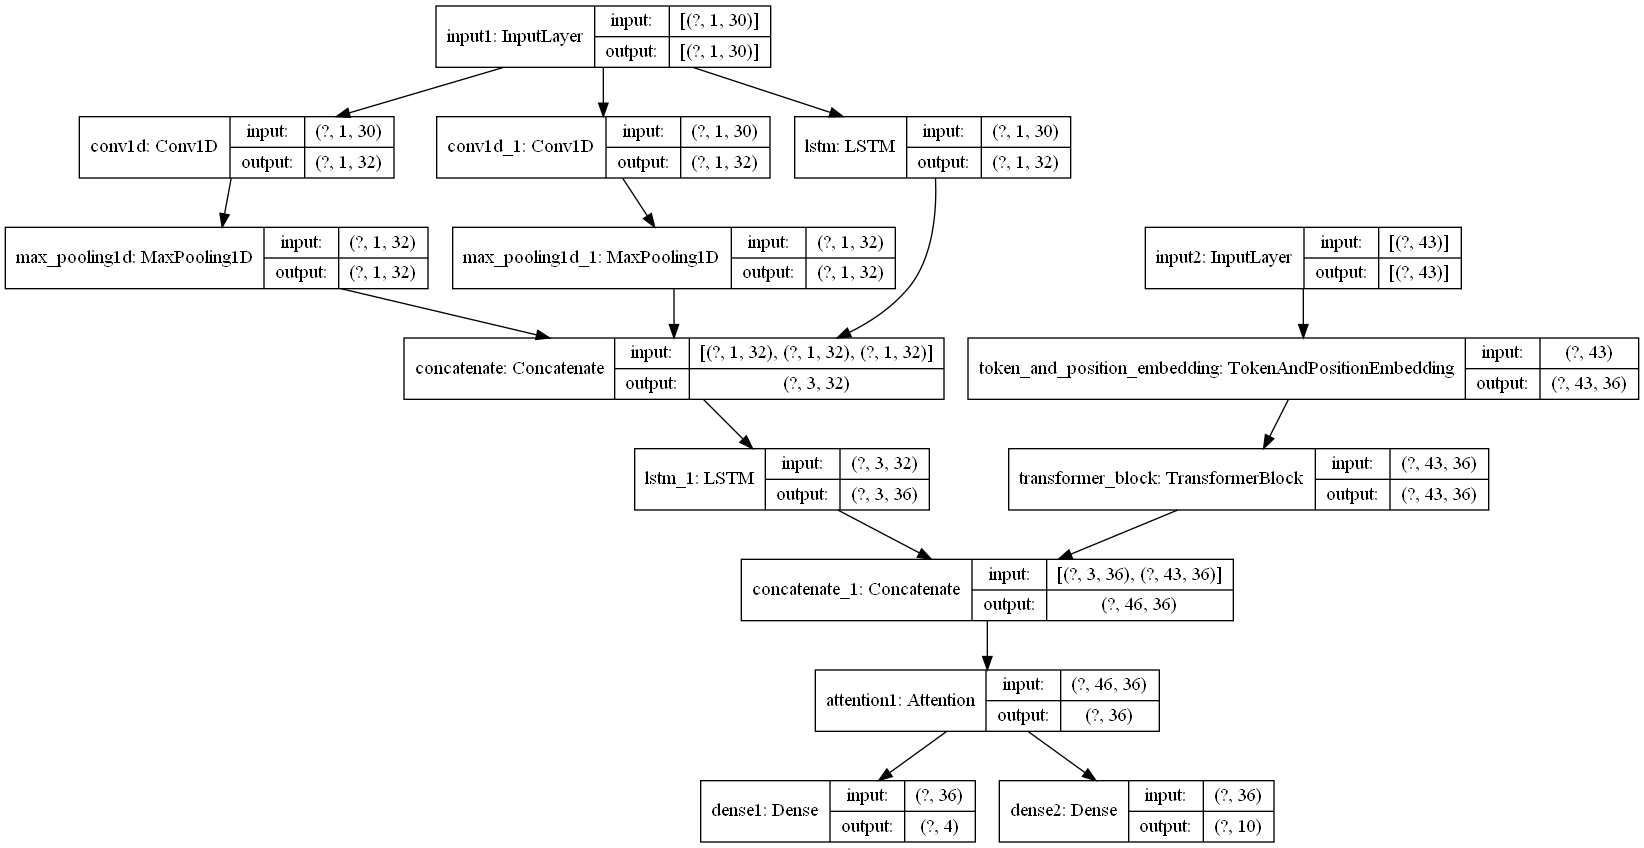

In [23]:
from tensorflow.keras.utils import plot_model
type_mode = 'Normal'
model = PB_TextRNN()
plot_model(model, show_shapes = True)

### K-Fold训练

In [22]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
seed = 42  # 随机种子
np.random.seed(seed)  # 生成固定的随机数
num_k = 5  # 多少折
# 整个数据集(自己定义)
X_ = X_l
Y_ = Y_l
kfold = StratifiedKFold(n_splits=num_k, shuffle=True, random_state=seed) 

In [23]:
results = []
NAME = 'TransNet'
k = 0#新建文件夹命名
for train, test in kfold.split(X_, Y_):
    type_mode = 'Normal'
    model = PB_TextRNN()
    k+=1
    path = os.path.join(r'D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage'+'/'+NAME+'_'+type_mode, str(k))
    if not os.path.exists(path):
         os.makedirs(path)
    filepath = path+ '/'+'{epoch:02d}^lt{loss:.4f}-Lt{dense1_acc:.4f}-Dt{dense2_acc:.4f}-lv{val_loss:.4f}-Lv{val_dense1_acc:.4f}-Dv{val_dense2_acc:.4f}.h5'
    checkpoint  = ModelCheckpoint(filepath=filepath,verbose=1,save_weights_only=False)
    earlystopper = EarlyStopping( monitor='dense1_loss',patience=5,verbose=2, mode = 'min')

    history=model.fit([x_train_l[train], x_train_d[train]], [Y_l[train], Y_d[train]], batch_size=500, epochs=1000,validation_split =0.3, verbose=2,callbacks=[earlystopper,checkpoint])
    scores = model.evaluate([x_train_l[test], x_train_d[test]], [Y_l[test], Y_d[test]], verbose=2)

#     history=model.fit([x_train_d[train]], [Y_l[train], Y_d[train]], batch_size=500, epochs=1000, verbose=2,callbacks=[earlystopper,checkpoint])
#     scores = model.evaluate([x_train_d[test]], [Y_l[test], Y_d[test]], verbose=2)
    results.append(scores)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 90270 samples, validate on 38688 samples
Epoch 1/1000

Epoch 00001: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/01^lt1.1031-Lt0.7902-Dt0.7914-lv0.6981-Lv0.8225-Dv0.8945.h5
90270/90270 - 5s - loss: 1.1031 - dense1_loss: 0.4859 - dense2_loss: 0.6158 - dense1_acc: 0.7902 - dense2_acc: 0.7914 - val_loss: 0.6981 - val_dense1_loss: 0.3916 - val_dense2_loss: 0.3057 - val_dense1_acc: 0.8225 - val_dense2_acc: 0.8945
Epoch 2/1000

Epoch 00002: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/02^lt0.6694-Lt0.8378-Dt0.8900-lv0.6482-Lv0.8323-Dv0.8970.h5
90270/90270 - 3s -

Epoch 18/1000

Epoch 00018: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/18^lt0.5284-Lt0.8598-Dt0.9127-lv0.6361-Lv0.8317-Dv0.9043.h5
90270/90270 - 3s - loss: 0.5284 - dense1_loss: 0.3166 - dense2_loss: 0.2116 - dense1_acc: 0.8598 - dense2_acc: 0.9127 - val_loss: 0.6361 - val_dense1_loss: 0.3699 - val_dense2_loss: 0.2669 - val_dense1_acc: 0.8317 - val_dense2_acc: 0.9043
Epoch 19/1000

Epoch 00019: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/19^lt0.5260-Lt0.8610-Dt0.9129-lv0.6311-Lv0.8297-Dv0.9107.h5
90270/90270 - 3s - loss: 0.5260 - dense1_loss: 0.3158 - dense2_loss: 0.2103 - dense1_acc: 0.8610 - dense2_acc: 0.9129 - val_loss: 0.6311 - val_dense1_loss: 0.3699 - val_dense2_loss: 0.2622 - val_dense1_acc: 0.8297 - val_dense2_acc: 0.9107
Epoch 20/1000

Epoch 00020: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 37/1000

Epoch 00037: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/37^lt0.4982-Lt0.8663-Dt0.9176-lv0.6812-Lv0.8219-Dv0.9060.h5
90270/90270 - 3s - loss: 0.4982 - dense1_loss: 0.3004 - dense2_loss: 0.1980 - dense1_acc: 0.8663 - dense2_acc: 0.9176 - val_loss: 0.6812 - val_dense1_loss: 0.4034 - val_dense2_loss: 0.2777 - val_dense1_acc: 0.8219 - val_dense2_acc: 0.9060
Epoch 38/1000

Epoch 00038: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/38^lt0.4970-Lt0.8672-Dt0.9172-lv0.6735-Lv0.8295-Dv0.8988.h5
90270/90270 - 3s - loss: 0.4970 - dense1_loss: 0.2994 - dense2_loss: 0.1975 - dense1_acc: 0.8672 - dense2_acc: 0.9172 - val_loss: 0.6735 - val_dense1_loss: 0.3878 - val_dense2_loss: 0.2857 - val_dense1_acc: 0.8295 - val_dense2_acc: 0.8988
Epoch 39/1000

Epoch 00039: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 56/1000

Epoch 00056: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/56^lt0.4773-Lt0.8723-Dt0.9202-lv0.6986-Lv0.8266-Dv0.9032.h5
90270/90270 - 3s - loss: 0.4773 - dense1_loss: 0.2878 - dense2_loss: 0.1896 - dense1_acc: 0.8723 - dense2_acc: 0.9202 - val_loss: 0.6986 - val_dense1_loss: 0.4080 - val_dense2_loss: 0.2894 - val_dense1_acc: 0.8266 - val_dense2_acc: 0.9032
Epoch 57/1000

Epoch 00057: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/57^lt0.4762-Lt0.8727-Dt0.9206-lv0.7195-Lv0.8223-Dv0.8990.h5
90270/90270 - 3s - loss: 0.4762 - dense1_loss: 0.2866 - dense2_loss: 0.1896 - dense1_acc: 0.8727 - dense2_acc: 0.9206 - val_loss: 0.7195 - val_dense1_loss: 0.4188 - val_dense2_loss: 0.3010 - val_dense1_acc: 0.8223 - val_dense2_acc: 0.8990
Epoch 58/1000

Epoch 00058: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 75/1000

Epoch 00075: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/75^lt0.4615-Lt0.8777-Dt0.9222-lv0.7245-Lv0.8251-Dv0.9039.h5
90270/90270 - 3s - loss: 0.4615 - dense1_loss: 0.2775 - dense2_loss: 0.1840 - dense1_acc: 0.8777 - dense2_acc: 0.9222 - val_loss: 0.7245 - val_dense1_loss: 0.4242 - val_dense2_loss: 0.2995 - val_dense1_acc: 0.8251 - val_dense2_acc: 0.9039
Epoch 76/1000

Epoch 00076: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/76^lt0.4603-Lt0.8781-Dt0.9221-lv0.7296-Lv0.8274-Dv0.9036.h5
90270/90270 - 3s - loss: 0.4603 - dense1_loss: 0.2763 - dense2_loss: 0.1839 - dense1_acc: 0.8781 - dense2_acc: 0.9221 - val_loss: 0.7296 - val_dense1_loss: 0.4255 - val_dense2_loss: 0.3044 - val_dense1_acc: 0.8274 - val_dense2_acc: 0.9036
Epoch 77/1000

Epoch 00077: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 94/1000

Epoch 00094: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/94^lt0.4492-Lt0.8813-Dt0.9234-lv0.7446-Lv0.8247-Dv0.9066.h5
90270/90270 - 3s - loss: 0.4492 - dense1_loss: 0.2692 - dense2_loss: 0.1800 - dense1_acc: 0.8813 - dense2_acc: 0.9234 - val_loss: 0.7446 - val_dense1_loss: 0.4372 - val_dense2_loss: 0.3069 - val_dense1_acc: 0.8247 - val_dense2_acc: 0.9066
Epoch 95/1000

Epoch 00095: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/95^lt0.4468-Lt0.8818-Dt0.9239-lv0.7644-Lv0.8239-Dv0.8942.h5
90270/90270 - 3s - loss: 0.4468 - dense1_loss: 0.2677 - dense2_loss: 0.1794 - dense1_acc: 0.8818 - dense2_acc: 0.9239 - val_loss: 0.7644 - val_dense1_loss: 0.4426 - val_dense2_loss: 0.3218 - val_dense1_acc: 0.8239 - val_dense2_acc: 0.8942
Epoch 96/1000

Epoch 00096: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 113/1000

Epoch 00113: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/113^lt0.4394-Lt0.8837-Dt0.9250-lv0.7761-Lv0.8220-Dv0.9036.h5
90270/90270 - 3s - loss: 0.4394 - dense1_loss: 0.2626 - dense2_loss: 0.1769 - dense1_acc: 0.8837 - dense2_acc: 0.9250 - val_loss: 0.7761 - val_dense1_loss: 0.4554 - val_dense2_loss: 0.3199 - val_dense1_acc: 0.8220 - val_dense2_acc: 0.9036
Epoch 114/1000

Epoch 00114: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/114^lt0.4381-Lt0.8844-Dt0.9249-lv0.7856-Lv0.8213-Dv0.9051.h5
90270/90270 - 3s - loss: 0.4381 - dense1_loss: 0.2619 - dense2_loss: 0.1763 - dense1_acc: 0.8844 - dense2_acc: 0.9249 - val_loss: 0.7856 - val_dense1_loss: 0.4673 - val_dense2_loss: 0.3203 - val_dense1_acc: 0.8213 - val_dense2_acc: 0.9051
Epoch 115/1000

Epoch 00115: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 132/1000

Epoch 00132: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/132^lt0.4327-Lt0.8857-Dt0.9258-lv0.7894-Lv0.8249-Dv0.9011.h5
90270/90270 - 3s - loss: 0.4327 - dense1_loss: 0.2584 - dense2_loss: 0.1745 - dense1_acc: 0.8857 - dense2_acc: 0.9258 - val_loss: 0.7894 - val_dense1_loss: 0.4614 - val_dense2_loss: 0.3289 - val_dense1_acc: 0.8249 - val_dense2_acc: 0.9011
Epoch 133/1000

Epoch 00133: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\1/133^lt0.4322-Lt0.8861-Dt0.9261-lv0.8202-Lv0.8188-Dv0.9011.h5
90270/90270 - 3s - loss: 0.4322 - dense1_loss: 0.2584 - dense2_loss: 0.1740 - dense1_acc: 0.8861 - dense2_acc: 0.9261 - val_loss: 0.8202 - val_dense1_loss: 0.4836 - val_dense2_loss: 0.3357 - val_dense1_acc: 0.8188 - val_dense2_acc: 0.9011
Epoch 00133: early stopping
32240/32240 - 4s - loss: 0.8318 - dense1_loss: 0.4661 - dense2_loss: 0.3658 - dense1_acc

Epoch 18/1000

Epoch 00018: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/18^lt0.5293-Lt0.8602-Dt0.9113-lv0.6328-Lv0.8288-Dv0.8982.h5
90270/90270 - 3s - loss: 0.5293 - dense1_loss: 0.3153 - dense2_loss: 0.2141 - dense1_acc: 0.8602 - dense2_acc: 0.9113 - val_loss: 0.6328 - val_dense1_loss: 0.3711 - val_dense2_loss: 0.2621 - val_dense1_acc: 0.8288 - val_dense2_acc: 0.8982
Epoch 19/1000

Epoch 00019: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/19^lt0.5259-Lt0.8616-Dt0.9110-lv0.6458-Lv0.8248-Dv0.9036.h5
90270/90270 - 3s - loss: 0.5259 - dense1_loss: 0.3131 - dense2_loss: 0.2125 - dense1_acc: 0.8616 - dense2_acc: 0.9110 - val_loss: 0.6458 - val_dense1_loss: 0.3838 - val_dense2_loss: 0.2638 - val_dense1_acc: 0.8248 - val_dense2_acc: 0.9036
Epoch 20/1000

Epoch 00020: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 37/1000

Epoch 00037: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/37^lt0.4964-Lt0.8682-Dt0.9157-lv0.6740-Lv0.8247-Dv0.9065.h5
90270/90270 - 3s - loss: 0.4964 - dense1_loss: 0.2959 - dense2_loss: 0.2005 - dense1_acc: 0.8682 - dense2_acc: 0.9157 - val_loss: 0.6740 - val_dense1_loss: 0.4001 - val_dense2_loss: 0.2743 - val_dense1_acc: 0.8247 - val_dense2_acc: 0.9065
Epoch 38/1000

Epoch 00038: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/38^lt0.4947-Lt0.8689-Dt0.9164-lv0.6580-Lv0.8293-Dv0.9096.h5
90270/90270 - 3s - loss: 0.4947 - dense1_loss: 0.2948 - dense2_loss: 0.1998 - dense1_acc: 0.8689 - dense2_acc: 0.9164 - val_loss: 0.6580 - val_dense1_loss: 0.3891 - val_dense2_loss: 0.2684 - val_dense1_acc: 0.8293 - val_dense2_acc: 0.9096
Epoch 39/1000

Epoch 00039: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 56/1000

Epoch 00056: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/56^lt0.4767-Lt0.8743-Dt0.9190-lv0.7106-Lv0.8188-Dv0.9058.h5
90270/90270 - 3s - loss: 0.4767 - dense1_loss: 0.2839 - dense2_loss: 0.1929 - dense1_acc: 0.8743 - dense2_acc: 0.9190 - val_loss: 0.7106 - val_dense1_loss: 0.4262 - val_dense2_loss: 0.2850 - val_dense1_acc: 0.8188 - val_dense2_acc: 0.9058
Epoch 57/1000

Epoch 00057: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/57^lt0.4755-Lt0.8743-Dt0.9194-lv0.6856-Lv0.8240-Dv0.9090.h5
90270/90270 - 3s - loss: 0.4755 - dense1_loss: 0.2833 - dense2_loss: 0.1921 - dense1_acc: 0.8743 - dense2_acc: 0.9194 - val_loss: 0.6856 - val_dense1_loss: 0.4068 - val_dense2_loss: 0.2782 - val_dense1_acc: 0.8240 - val_dense2_acc: 0.9090
Epoch 58/1000

Epoch 00058: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 75/1000

Epoch 00075: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/75^lt0.4636-Lt0.8774-Dt0.9202-lv0.7106-Lv0.8248-Dv0.9054.h5
90270/90270 - 3s - loss: 0.4636 - dense1_loss: 0.2758 - dense2_loss: 0.1878 - dense1_acc: 0.8774 - dense2_acc: 0.9202 - val_loss: 0.7106 - val_dense1_loss: 0.4202 - val_dense2_loss: 0.2919 - val_dense1_acc: 0.8248 - val_dense2_acc: 0.9054
Epoch 76/1000

Epoch 00076: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/76^lt0.4619-Lt0.8779-Dt0.9210-lv0.7151-Lv0.8273-Dv0.8996.h5
90270/90270 - 3s - loss: 0.4619 - dense1_loss: 0.2745 - dense2_loss: 0.1872 - dense1_acc: 0.8779 - dense2_acc: 0.9210 - val_loss: 0.7151 - val_dense1_loss: 0.4167 - val_dense2_loss: 0.2970 - val_dense1_acc: 0.8273 - val_dense2_acc: 0.8996
Epoch 77/1000

Epoch 00077: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 94/1000

Epoch 00094: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/94^lt0.4509-Lt0.8814-Dt0.9220-lv0.7338-Lv0.8254-Dv0.9033.h5
90270/90270 - 3s - loss: 0.4509 - dense1_loss: 0.2683 - dense2_loss: 0.1826 - dense1_acc: 0.8814 - dense2_acc: 0.9220 - val_loss: 0.7338 - val_dense1_loss: 0.4301 - val_dense2_loss: 0.3038 - val_dense1_acc: 0.8254 - val_dense2_acc: 0.9033
Epoch 95/1000

Epoch 00095: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/95^lt0.4524-Lt0.8815-Dt0.9223-lv0.7650-Lv0.8199-Dv0.9010.h5
90270/90270 - 3s - loss: 0.4524 - dense1_loss: 0.2690 - dense2_loss: 0.1836 - dense1_acc: 0.8815 - dense2_acc: 0.9223 - val_loss: 0.7650 - val_dense1_loss: 0.4569 - val_dense2_loss: 0.3073 - val_dense1_acc: 0.8199 - val_dense2_acc: 0.9010
Epoch 96/1000

Epoch 00096: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 113/1000

Epoch 00113: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/113^lt0.4429-Lt0.8837-Dt0.9235-lv0.7652-Lv0.8226-Dv0.9064.h5
90270/90270 - 3s - loss: 0.4429 - dense1_loss: 0.2630 - dense2_loss: 0.1798 - dense1_acc: 0.8837 - dense2_acc: 0.9235 - val_loss: 0.7652 - val_dense1_loss: 0.4571 - val_dense2_loss: 0.3097 - val_dense1_acc: 0.8226 - val_dense2_acc: 0.9064
Epoch 114/1000

Epoch 00114: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/114^lt0.4420-Lt0.8841-Dt0.9236-lv0.7862-Lv0.8196-Dv0.9045.h5
90270/90270 - 3s - loss: 0.4420 - dense1_loss: 0.2622 - dense2_loss: 0.1798 - dense1_acc: 0.8841 - dense2_acc: 0.9236 - val_loss: 0.7862 - val_dense1_loss: 0.4743 - val_dense2_loss: 0.3133 - val_dense1_acc: 0.8196 - val_dense2_acc: 0.9045
Epoch 115/1000

Epoch 00115: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 132/1000

Epoch 00132: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/132^lt0.4360-Lt0.8855-Dt0.9251-lv0.7920-Lv0.8227-Dv0.9056.h5
90270/90270 - 3s - loss: 0.4360 - dense1_loss: 0.2585 - dense2_loss: 0.1775 - dense1_acc: 0.8855 - dense2_acc: 0.9251 - val_loss: 0.7920 - val_dense1_loss: 0.4723 - val_dense2_loss: 0.3201 - val_dense1_acc: 0.8227 - val_dense2_acc: 0.9056
Epoch 133/1000

Epoch 00133: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/133^lt0.4352-Lt0.8862-Dt0.9242-lv0.7925-Lv0.8200-Dv0.9011.h5
90270/90270 - 3s - loss: 0.4352 - dense1_loss: 0.2573 - dense2_loss: 0.1778 - dense1_acc: 0.8862 - dense2_acc: 0.9242 - val_loss: 0.7925 - val_dense1_loss: 0.4735 - val_dense2_loss: 0.3178 - val_dense1_acc: 0.8200 - val_dense2_acc: 0.9011
Epoch 134/1000

Epoch 00134: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 151/1000

Epoch 00151: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/151^lt0.4296-Lt0.8869-Dt0.9254-lv0.8106-Lv0.8192-Dv0.9042.h5
90270/90270 - 3s - loss: 0.4296 - dense1_loss: 0.2541 - dense2_loss: 0.1755 - dense1_acc: 0.8869 - dense2_acc: 0.9254 - val_loss: 0.8106 - val_dense1_loss: 0.4892 - val_dense2_loss: 0.3216 - val_dense1_acc: 0.8192 - val_dense2_acc: 0.9042
Epoch 152/1000

Epoch 00152: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/152^lt0.4310-Lt0.8865-Dt0.9248-lv0.7990-Lv0.8206-Dv0.9068.h5
90270/90270 - 3s - loss: 0.4310 - dense1_loss: 0.2545 - dense2_loss: 0.1764 - dense1_acc: 0.8865 - dense2_acc: 0.9248 - val_loss: 0.7990 - val_dense1_loss: 0.4823 - val_dense2_loss: 0.3180 - val_dense1_acc: 0.8206 - val_dense2_acc: 0.9068
Epoch 153/1000

Epoch 00153: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 170/1000

Epoch 00170: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/170^lt0.4255-Lt0.8881-Dt0.9266-lv0.8362-Lv0.8184-Dv0.9044.h5
90270/90270 - 3s - loss: 0.4255 - dense1_loss: 0.2524 - dense2_loss: 0.1729 - dense1_acc: 0.8881 - dense2_acc: 0.9266 - val_loss: 0.8362 - val_dense1_loss: 0.5097 - val_dense2_loss: 0.3294 - val_dense1_acc: 0.8184 - val_dense2_acc: 0.9044
Epoch 171/1000

Epoch 00171: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/171^lt0.4237-Lt0.8897-Dt0.9263-lv0.8398-Lv0.8177-Dv0.9025.h5
90270/90270 - 3s - loss: 0.4237 - dense1_loss: 0.2504 - dense2_loss: 0.1732 - dense1_acc: 0.8897 - dense2_acc: 0.9263 - val_loss: 0.8398 - val_dense1_loss: 0.5076 - val_dense2_loss: 0.3332 - val_dense1_acc: 0.8177 - val_dense2_acc: 0.9025
Epoch 172/1000

Epoch 00172: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 189/1000

Epoch 00189: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/189^lt0.4205-Lt0.8902-Dt0.9267-lv0.8432-Lv0.8196-Dv0.8998.h5
90270/90270 - 3s - loss: 0.4205 - dense1_loss: 0.2479 - dense2_loss: 0.1725 - dense1_acc: 0.8902 - dense2_acc: 0.9267 - val_loss: 0.8432 - val_dense1_loss: 0.5048 - val_dense2_loss: 0.3379 - val_dense1_acc: 0.8196 - val_dense2_acc: 0.8998
Epoch 190/1000

Epoch 00190: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\2/190^lt0.4194-Lt0.8902-Dt0.9264-lv0.8417-Lv0.8181-Dv0.8989.h5
90270/90270 - 3s - loss: 0.4194 - dense1_loss: 0.2475 - dense2_loss: 0.1720 - dense1_acc: 0.8902 - dense2_acc: 0.9264 - val_loss: 0.8417 - val_dense1_loss: 0.5085 - val_dense2_loss: 0.3336 - val_dense1_acc: 0.8181 - val_dense2_acc: 0.8989
Epoch 191/1000

Epoch 00191: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 4/1000

Epoch 00004: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/04^lt0.5999-Lt0.8493-Dt0.9001-lv0.6412-Lv0.8201-Dv0.9064.h5
90270/90270 - 3s - loss: 0.5999 - dense1_loss: 0.3467 - dense2_loss: 0.2532 - dense1_acc: 0.8493 - dense2_acc: 0.9001 - val_loss: 0.6412 - val_dense1_loss: 0.3802 - val_dense2_loss: 0.2611 - val_dense1_acc: 0.8201 - val_dense2_acc: 0.9064
Epoch 5/1000

Epoch 00005: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/05^lt0.5864-Lt0.8517-Dt0.9019-lv0.6396-Lv0.8280-Dv0.8955.h5
90270/90270 - 3s - loss: 0.5864 - dense1_loss: 0.3403 - dense2_loss: 0.2461 - dense1_acc: 0.8517 - dense2_acc: 0.9019 - val_loss: 0.6396 - val_dense1_loss: 0.3695 - val_dense2_loss: 0.2707 - val_dense1_acc: 0.8280 - val_dense2_acc: 0.8955
Epoch 6/1000

Epoch 00006: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/

Epoch 23/1000

Epoch 00023: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/23^lt0.5173-Lt0.8625-Dt0.9132-lv0.6443-Lv0.8303-Dv0.9068.h5
90270/90270 - 3s - loss: 0.5173 - dense1_loss: 0.3090 - dense2_loss: 0.2080 - dense1_acc: 0.8625 - dense2_acc: 0.9132 - val_loss: 0.6443 - val_dense1_loss: 0.3770 - val_dense2_loss: 0.2677 - val_dense1_acc: 0.8303 - val_dense2_acc: 0.9068
Epoch 24/1000

Epoch 00024: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/24^lt0.5162-Lt0.8624-Dt0.9131-lv0.6513-Lv0.8297-Dv0.9057.h5
90270/90270 - 3s - loss: 0.5162 - dense1_loss: 0.3081 - dense2_loss: 0.2080 - dense1_acc: 0.8624 - dense2_acc: 0.9131 - val_loss: 0.6513 - val_dense1_loss: 0.3805 - val_dense2_loss: 0.2713 - val_dense1_acc: 0.8297 - val_dense2_acc: 0.9057
Epoch 25/1000

Epoch 00025: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 42/1000

Epoch 00042: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/42^lt0.4923-Lt0.8704-Dt0.9165-lv0.6936-Lv0.8235-Dv0.9028.h5
90270/90270 - 3s - loss: 0.4923 - dense1_loss: 0.2936 - dense2_loss: 0.1987 - dense1_acc: 0.8704 - dense2_acc: 0.9165 - val_loss: 0.6936 - val_dense1_loss: 0.4119 - val_dense2_loss: 0.2802 - val_dense1_acc: 0.8235 - val_dense2_acc: 0.9028
Epoch 43/1000

Epoch 00043: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/43^lt0.4903-Lt0.8700-Dt0.9167-lv0.6802-Lv0.8273-Dv0.8999.h5
90270/90270 - 3s - loss: 0.4903 - dense1_loss: 0.2924 - dense2_loss: 0.1978 - dense1_acc: 0.8700 - dense2_acc: 0.9167 - val_loss: 0.6802 - val_dense1_loss: 0.3972 - val_dense2_loss: 0.2825 - val_dense1_acc: 0.8273 - val_dense2_acc: 0.8999
Epoch 44/1000

Epoch 00044: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 61/1000

Epoch 00061: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/61^lt0.4726-Lt0.8754-Dt0.9201-lv0.6905-Lv0.8259-Dv0.9111.h5
90270/90270 - 3s - loss: 0.4726 - dense1_loss: 0.2812 - dense2_loss: 0.1916 - dense1_acc: 0.8754 - dense2_acc: 0.9201 - val_loss: 0.6905 - val_dense1_loss: 0.4088 - val_dense2_loss: 0.2830 - val_dense1_acc: 0.8259 - val_dense2_acc: 0.9111
Epoch 62/1000

Epoch 00062: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/62^lt0.4723-Lt0.8760-Dt0.9191-lv0.6980-Lv0.8256-Dv0.9035.h5
90270/90270 - 3s - loss: 0.4723 - dense1_loss: 0.2804 - dense2_loss: 0.1917 - dense1_acc: 0.8760 - dense2_acc: 0.9191 - val_loss: 0.6980 - val_dense1_loss: 0.4075 - val_dense2_loss: 0.2913 - val_dense1_acc: 0.8256 - val_dense2_acc: 0.9035
Epoch 63/1000

Epoch 00063: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 80/1000

Epoch 00080: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/80^lt0.4602-Lt0.8786-Dt0.9207-lv0.7330-Lv0.8192-Dv0.9082.h5
90270/90270 - 3s - loss: 0.4602 - dense1_loss: 0.2732 - dense2_loss: 0.1871 - dense1_acc: 0.8786 - dense2_acc: 0.9207 - val_loss: 0.7330 - val_dense1_loss: 0.4399 - val_dense2_loss: 0.2928 - val_dense1_acc: 0.8192 - val_dense2_acc: 0.9082
Epoch 81/1000

Epoch 00081: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/81^lt0.4581-Lt0.8805-Dt0.9213-lv0.7162-Lv0.8264-Dv0.9098.h5
90270/90270 - 3s - loss: 0.4581 - dense1_loss: 0.2716 - dense2_loss: 0.1867 - dense1_acc: 0.8805 - dense2_acc: 0.9213 - val_loss: 0.7162 - val_dense1_loss: 0.4248 - val_dense2_loss: 0.2922 - val_dense1_acc: 0.8264 - val_dense2_acc: 0.9098
Epoch 82/1000

Epoch 00082: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 99/1000

Epoch 00099: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/99^lt0.4471-Lt0.8830-Dt0.9228-lv0.7630-Lv0.8159-Dv0.9028.h5
90270/90270 - 3s - loss: 0.4471 - dense1_loss: 0.2652 - dense2_loss: 0.1818 - dense1_acc: 0.8830 - dense2_acc: 0.9228 - val_loss: 0.7630 - val_dense1_loss: 0.4534 - val_dense2_loss: 0.3100 - val_dense1_acc: 0.8159 - val_dense2_acc: 0.9028
Epoch 100/1000

Epoch 00100: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/100^lt0.4475-Lt0.8832-Dt0.9230-lv0.7462-Lv0.8273-Dv0.8993.h5
90270/90270 - 3s - loss: 0.4475 - dense1_loss: 0.2650 - dense2_loss: 0.1829 - dense1_acc: 0.8832 - dense2_acc: 0.9230 - val_loss: 0.7462 - val_dense1_loss: 0.4322 - val_dense2_loss: 0.3133 - val_dense1_acc: 0.8273 - val_dense2_acc: 0.8993
Epoch 101/1000

Epoch 00101: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRet

Epoch 118/1000

Epoch 00118: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/118^lt0.4393-Lt0.8848-Dt0.9243-lv0.7804-Lv0.8209-Dv0.8985.h5
90270/90270 - 3s - loss: 0.4393 - dense1_loss: 0.2601 - dense2_loss: 0.1793 - dense1_acc: 0.8848 - dense2_acc: 0.9243 - val_loss: 0.7804 - val_dense1_loss: 0.4590 - val_dense2_loss: 0.3242 - val_dense1_acc: 0.8209 - val_dense2_acc: 0.8985
Epoch 119/1000

Epoch 00119: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/119^lt0.4387-Lt0.8854-Dt0.9238-lv0.7773-Lv0.8184-Dv0.9050.h5
90270/90270 - 3s - loss: 0.4387 - dense1_loss: 0.2596 - dense2_loss: 0.1793 - dense1_acc: 0.8854 - dense2_acc: 0.9238 - val_loss: 0.7773 - val_dense1_loss: 0.4605 - val_dense2_loss: 0.3162 - val_dense1_acc: 0.8184 - val_dense2_acc: 0.9050
Epoch 120/1000

Epoch 00120: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 137/1000

Epoch 00137: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/137^lt0.4335-Lt0.8863-Dt0.9248-lv0.7891-Lv0.8193-Dv0.9050.h5
90270/90270 - 3s - loss: 0.4335 - dense1_loss: 0.2563 - dense2_loss: 0.1772 - dense1_acc: 0.8863 - dense2_acc: 0.9248 - val_loss: 0.7891 - val_dense1_loss: 0.4693 - val_dense2_loss: 0.3189 - val_dense1_acc: 0.8193 - val_dense2_acc: 0.9050
Epoch 138/1000

Epoch 00138: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/138^lt0.4335-Lt0.8868-Dt0.9247-lv0.7896-Lv0.8214-Dv0.8982.h5
90270/90270 - 3s - loss: 0.4335 - dense1_loss: 0.2561 - dense2_loss: 0.1775 - dense1_acc: 0.8868 - dense2_acc: 0.9247 - val_loss: 0.7896 - val_dense1_loss: 0.4657 - val_dense2_loss: 0.3237 - val_dense1_acc: 0.8214 - val_dense2_acc: 0.8982
Epoch 139/1000

Epoch 00139: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 156/1000

Epoch 00156: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/156^lt0.4276-Lt0.8887-Dt0.9259-lv0.8080-Lv0.8218-Dv0.9045.h5
90270/90270 - 3s - loss: 0.4276 - dense1_loss: 0.2524 - dense2_loss: 0.1753 - dense1_acc: 0.8887 - dense2_acc: 0.9259 - val_loss: 0.8080 - val_dense1_loss: 0.4791 - val_dense2_loss: 0.3287 - val_dense1_acc: 0.8218 - val_dense2_acc: 0.9045
Epoch 157/1000

Epoch 00157: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\3/157^lt0.4281-Lt0.8890-Dt0.9252-lv0.7988-Lv0.8227-Dv0.9039.h5
90270/90270 - 3s - loss: 0.4281 - dense1_loss: 0.2522 - dense2_loss: 0.1759 - dense1_acc: 0.8890 - dense2_acc: 0.9252 - val_loss: 0.7988 - val_dense1_loss: 0.4749 - val_dense2_loss: 0.3242 - val_dense1_acc: 0.8227 - val_dense2_acc: 0.9039
Epoch 158/1000

Epoch 00158: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 17/1000

Epoch 00017: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/17^lt0.5353-Lt0.8587-Dt0.9097-lv0.6256-Lv0.8304-Dv0.9150.h5
90271/90271 - 3s - loss: 0.5353 - dense1_loss: 0.3168 - dense2_loss: 0.2185 - dense1_acc: 0.8587 - dense2_acc: 0.9097 - val_loss: 0.6256 - val_dense1_loss: 0.3733 - val_dense2_loss: 0.2525 - val_dense1_acc: 0.8304 - val_dense2_acc: 0.9150
Epoch 18/1000

Epoch 00018: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/18^lt0.5330-Lt0.8602-Dt0.9104-lv0.6441-Lv0.8328-Dv0.8932.h5
90271/90271 - 3s - loss: 0.5330 - dense1_loss: 0.3159 - dense2_loss: 0.2169 - dense1_acc: 0.8602 - dense2_acc: 0.9104 - val_loss: 0.6441 - val_dense1_loss: 0.3690 - val_dense2_loss: 0.2761 - val_dense1_acc: 0.8328 - val_dense2_acc: 0.8932
Epoch 19/1000

Epoch 00019: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 36/1000

Epoch 00036: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/36^lt0.5046-Lt0.8666-Dt0.9154-lv0.6682-Lv0.8289-Dv0.8973.h5
90271/90271 - 3s - loss: 0.5046 - dense1_loss: 0.3000 - dense2_loss: 0.2044 - dense1_acc: 0.8666 - dense2_acc: 0.9154 - val_loss: 0.6682 - val_dense1_loss: 0.3910 - val_dense2_loss: 0.2772 - val_dense1_acc: 0.8289 - val_dense2_acc: 0.8973
Epoch 37/1000

Epoch 00037: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/37^lt0.5039-Lt0.8670-Dt0.9156-lv0.6620-Lv0.8256-Dv0.9102.h5
90271/90271 - 3s - loss: 0.5039 - dense1_loss: 0.2995 - dense2_loss: 0.2045 - dense1_acc: 0.8670 - dense2_acc: 0.9156 - val_loss: 0.6620 - val_dense1_loss: 0.3943 - val_dense2_loss: 0.2690 - val_dense1_acc: 0.8256 - val_dense2_acc: 0.9102
Epoch 38/1000

Epoch 00038: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 55/1000

Epoch 00055: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/55^lt0.4831-Lt0.8719-Dt0.9185-lv0.6868-Lv0.8292-Dv0.9042.h5
90271/90271 - 3s - loss: 0.4831 - dense1_loss: 0.2870 - dense2_loss: 0.1960 - dense1_acc: 0.8719 - dense2_acc: 0.9185 - val_loss: 0.6868 - val_dense1_loss: 0.4028 - val_dense2_loss: 0.2840 - val_dense1_acc: 0.8292 - val_dense2_acc: 0.9042
Epoch 56/1000

Epoch 00056: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/56^lt0.4817-Lt0.8732-Dt0.9186-lv0.6971-Lv0.8271-Dv0.9015.h5
90271/90271 - 3s - loss: 0.4817 - dense1_loss: 0.2862 - dense2_loss: 0.1954 - dense1_acc: 0.8732 - dense2_acc: 0.9186 - val_loss: 0.6971 - val_dense1_loss: 0.4101 - val_dense2_loss: 0.2854 - val_dense1_acc: 0.8271 - val_dense2_acc: 0.9015
Epoch 57/1000

Epoch 00057: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 74/1000

Epoch 00074: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/74^lt0.4664-Lt0.8779-Dt0.9202-lv0.7351-Lv0.8209-Dv0.9080.h5
90271/90271 - 3s - loss: 0.4664 - dense1_loss: 0.2759 - dense2_loss: 0.1908 - dense1_acc: 0.8779 - dense2_acc: 0.9202 - val_loss: 0.7351 - val_dense1_loss: 0.4449 - val_dense2_loss: 0.2886 - val_dense1_acc: 0.8209 - val_dense2_acc: 0.9080
Epoch 75/1000

Epoch 00075: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/75^lt0.4665-Lt0.8772-Dt0.9203-lv0.7312-Lv0.8233-Dv0.9053.h5
90271/90271 - 3s - loss: 0.4665 - dense1_loss: 0.2762 - dense2_loss: 0.1902 - dense1_acc: 0.8772 - dense2_acc: 0.9203 - val_loss: 0.7312 - val_dense1_loss: 0.4386 - val_dense2_loss: 0.2934 - val_dense1_acc: 0.8233 - val_dense2_acc: 0.9053
Epoch 76/1000

Epoch 00076: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 93/1000

Epoch 00093: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/93^lt0.4544-Lt0.8812-Dt0.9224-lv0.7378-Lv0.8268-Dv0.9075.h5
90271/90271 - 3s - loss: 0.4544 - dense1_loss: 0.2684 - dense2_loss: 0.1861 - dense1_acc: 0.8812 - dense2_acc: 0.9224 - val_loss: 0.7378 - val_dense1_loss: 0.4446 - val_dense2_loss: 0.2943 - val_dense1_acc: 0.8268 - val_dense2_acc: 0.9075
Epoch 94/1000

Epoch 00094: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/94^lt0.4543-Lt0.8802-Dt0.9223-lv0.7687-Lv0.8178-Dv0.9068.h5
90271/90271 - 3s - loss: 0.4543 - dense1_loss: 0.2688 - dense2_loss: 0.1853 - dense1_acc: 0.8802 - dense2_acc: 0.9223 - val_loss: 0.7687 - val_dense1_loss: 0.4716 - val_dense2_loss: 0.2972 - val_dense1_acc: 0.8178 - val_dense2_acc: 0.9068
Epoch 95/1000

Epoch 00095: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 112/1000

Epoch 00112: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/112^lt0.4449-Lt0.8832-Dt0.9245-lv0.7982-Lv0.8195-Dv0.8994.h5
90271/90271 - 3s - loss: 0.4449 - dense1_loss: 0.2628 - dense2_loss: 0.1821 - dense1_acc: 0.8832 - dense2_acc: 0.9245 - val_loss: 0.7982 - val_dense1_loss: 0.4799 - val_dense2_loss: 0.3186 - val_dense1_acc: 0.8195 - val_dense2_acc: 0.8994
Epoch 113/1000

Epoch 00113: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/113^lt0.4441-Lt0.8840-Dt0.9235-lv0.7828-Lv0.8228-Dv0.8978.h5
90271/90271 - 3s - loss: 0.4441 - dense1_loss: 0.2618 - dense2_loss: 0.1823 - dense1_acc: 0.8840 - dense2_acc: 0.9235 - val_loss: 0.7828 - val_dense1_loss: 0.4654 - val_dense2_loss: 0.3166 - val_dense1_acc: 0.8228 - val_dense2_acc: 0.8978
Epoch 114/1000

Epoch 00114: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 131/1000

Epoch 00131: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/131^lt0.4356-Lt0.8857-Dt0.9252-lv0.8175-Lv0.8160-Dv0.9030.h5
90271/90271 - 3s - loss: 0.4356 - dense1_loss: 0.2566 - dense2_loss: 0.1790 - dense1_acc: 0.8857 - dense2_acc: 0.9252 - val_loss: 0.8175 - val_dense1_loss: 0.4971 - val_dense2_loss: 0.3194 - val_dense1_acc: 0.8160 - val_dense2_acc: 0.9030
Epoch 132/1000

Epoch 00132: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/132^lt0.4368-Lt0.8855-Dt0.9248-lv0.8085-Lv0.8230-Dv0.9033.h5
90271/90271 - 3s - loss: 0.4368 - dense1_loss: 0.2575 - dense2_loss: 0.1793 - dense1_acc: 0.8855 - dense2_acc: 0.9248 - val_loss: 0.8085 - val_dense1_loss: 0.4864 - val_dense2_loss: 0.3210 - val_dense1_acc: 0.8230 - val_dense2_acc: 0.9033
Epoch 133/1000

Epoch 00133: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 150/1000

Epoch 00150: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/150^lt0.4314-Lt0.8864-Dt0.9249-lv0.8101-Lv0.8197-Dv0.9013.h5
90271/90271 - 3s - loss: 0.4314 - dense1_loss: 0.2539 - dense2_loss: 0.1775 - dense1_acc: 0.8864 - dense2_acc: 0.9249 - val_loss: 0.8101 - val_dense1_loss: 0.4879 - val_dense2_loss: 0.3223 - val_dense1_acc: 0.8197 - val_dense2_acc: 0.9013
Epoch 151/1000

Epoch 00151: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\4/151^lt0.4303-Lt0.8866-Dt0.9252-lv0.8190-Lv0.8191-Dv0.9013.h5
90271/90271 - 3s - loss: 0.4303 - dense1_loss: 0.2535 - dense2_loss: 0.1768 - dense1_acc: 0.8866 - dense2_acc: 0.9252 - val_loss: 0.8190 - val_dense1_loss: 0.4960 - val_dense2_loss: 0.3219 - val_dense1_acc: 0.8191 - val_dense2_acc: 0.9013
Epoch 152/1000

Epoch 00152: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 9/1000

Epoch 00009: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/09^lt0.5645-Lt0.8537-Dt0.9049-lv0.6251-Lv0.8336-Dv0.9038.h5
90271/90271 - 3s - loss: 0.5645 - dense1_loss: 0.3318 - dense2_loss: 0.2324 - dense1_acc: 0.8537 - dense2_acc: 0.9049 - val_loss: 0.6251 - val_dense1_loss: 0.3607 - val_dense2_loss: 0.2642 - val_dense1_acc: 0.8336 - val_dense2_acc: 0.9038
Epoch 10/1000

Epoch 00010: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/10^lt0.5596-Lt0.8539-Dt0.9060-lv0.6347-Lv0.8312-Dv0.8894.h5
90271/90271 - 3s - loss: 0.5596 - dense1_loss: 0.3307 - dense2_loss: 0.2292 - dense1_acc: 0.8539 - dense2_acc: 0.9060 - val_loss: 0.6347 - val_dense1_loss: 0.3615 - val_dense2_loss: 0.2739 - val_dense1_acc: 0.8312 - val_dense2_acc: 0.8894
Epoch 11/1000

Epoch 00011: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriag

Epoch 28/1000

Epoch 00028: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/28^lt0.5114-Lt0.8639-Dt0.9132-lv0.6363-Lv0.8308-Dv0.9094.h5
90271/90271 - 3s - loss: 0.5114 - dense1_loss: 0.3051 - dense2_loss: 0.2066 - dense1_acc: 0.8639 - dense2_acc: 0.9132 - val_loss: 0.6363 - val_dense1_loss: 0.3724 - val_dense2_loss: 0.2642 - val_dense1_acc: 0.8308 - val_dense2_acc: 0.9094
Epoch 29/1000

Epoch 00029: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/29^lt0.5089-Lt0.8656-Dt0.9143-lv0.6471-Lv0.8266-Dv0.9127.h5
90271/90271 - 3s - loss: 0.5089 - dense1_loss: 0.3041 - dense2_loss: 0.2048 - dense1_acc: 0.8656 - dense2_acc: 0.9143 - val_loss: 0.6471 - val_dense1_loss: 0.3835 - val_dense2_loss: 0.2638 - val_dense1_acc: 0.8266 - val_dense2_acc: 0.9127
Epoch 30/1000

Epoch 00030: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 47/1000

Epoch 00047: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/47^lt0.4860-Lt0.8710-Dt0.9182-lv0.6772-Lv0.8310-Dv0.9022.h5
90271/90271 - 3s - loss: 0.4860 - dense1_loss: 0.2899 - dense2_loss: 0.1961 - dense1_acc: 0.8710 - dense2_acc: 0.9182 - val_loss: 0.6772 - val_dense1_loss: 0.3923 - val_dense2_loss: 0.2857 - val_dense1_acc: 0.8310 - val_dense2_acc: 0.9022
Epoch 48/1000

Epoch 00048: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/48^lt0.4841-Lt0.8715-Dt0.9181-lv0.6827-Lv0.8272-Dv0.9028.h5
90271/90271 - 3s - loss: 0.4841 - dense1_loss: 0.2892 - dense2_loss: 0.1950 - dense1_acc: 0.8715 - dense2_acc: 0.9181 - val_loss: 0.6827 - val_dense1_loss: 0.4002 - val_dense2_loss: 0.2818 - val_dense1_acc: 0.8272 - val_dense2_acc: 0.9028
Epoch 49/1000

Epoch 00049: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 66/1000

Epoch 00066: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/66^lt0.4681-Lt0.8754-Dt0.9206-lv0.7110-Lv0.8286-Dv0.9024.h5
90271/90271 - 3s - loss: 0.4681 - dense1_loss: 0.2789 - dense2_loss: 0.1892 - dense1_acc: 0.8754 - dense2_acc: 0.9206 - val_loss: 0.7110 - val_dense1_loss: 0.4141 - val_dense2_loss: 0.2961 - val_dense1_acc: 0.8286 - val_dense2_acc: 0.9024
Epoch 67/1000

Epoch 00067: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/67^lt0.4670-Lt0.8765-Dt0.9204-lv0.7071-Lv0.8291-Dv0.9020.h5
90271/90271 - 3s - loss: 0.4670 - dense1_loss: 0.2774 - dense2_loss: 0.1895 - dense1_acc: 0.8765 - dense2_acc: 0.9204 - val_loss: 0.7071 - val_dense1_loss: 0.4146 - val_dense2_loss: 0.2928 - val_dense1_acc: 0.8291 - val_dense2_acc: 0.9020
Epoch 68/1000

Epoch 00068: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 85/1000

Epoch 00085: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/85^lt0.4569-Lt0.8793-Dt0.9217-lv0.7262-Lv0.8302-Dv0.9035.h5
90271/90271 - 3s - loss: 0.4569 - dense1_loss: 0.2717 - dense2_loss: 0.1851 - dense1_acc: 0.8793 - dense2_acc: 0.9217 - val_loss: 0.7262 - val_dense1_loss: 0.4254 - val_dense2_loss: 0.3005 - val_dense1_acc: 0.8302 - val_dense2_acc: 0.9035
Epoch 86/1000

Epoch 00086: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/86^lt0.4556-Lt0.8793-Dt0.9224-lv0.7386-Lv0.8257-Dv0.9096.h5
90271/90271 - 3s - loss: 0.4556 - dense1_loss: 0.2713 - dense2_loss: 0.1842 - dense1_acc: 0.8793 - dense2_acc: 0.9224 - val_loss: 0.7386 - val_dense1_loss: 0.4405 - val_dense2_loss: 0.2979 - val_dense1_acc: 0.8257 - val_dense2_acc: 0.9096
Epoch 87/1000

Epoch 00087: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetria

Epoch 104/1000

Epoch 00104: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/104^lt0.4460-Lt0.8817-Dt0.9236-lv0.7519-Lv0.8261-Dv0.9060.h5
90271/90271 - 3s - loss: 0.4460 - dense1_loss: 0.2652 - dense2_loss: 0.1807 - dense1_acc: 0.8817 - dense2_acc: 0.9236 - val_loss: 0.7519 - val_dense1_loss: 0.4439 - val_dense2_loss: 0.3077 - val_dense1_acc: 0.8261 - val_dense2_acc: 0.9060
Epoch 105/1000

Epoch 00105: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/105^lt0.4444-Lt0.8819-Dt0.9228-lv0.7700-Lv0.8271-Dv0.9054.h5
90271/90271 - 3s - loss: 0.4444 - dense1_loss: 0.2639 - dense2_loss: 0.1806 - dense1_acc: 0.8819 - dense2_acc: 0.9228 - val_loss: 0.7700 - val_dense1_loss: 0.4554 - val_dense2_loss: 0.3135 - val_dense1_acc: 0.8271 - val_dense2_acc: 0.9054
Epoch 106/1000

Epoch 00106: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 123/1000

Epoch 00123: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/123^lt0.4384-Lt0.8837-Dt0.9246-lv0.7897-Lv0.8254-Dv0.9057.h5
90271/90271 - 3s - loss: 0.4384 - dense1_loss: 0.2600 - dense2_loss: 0.1784 - dense1_acc: 0.8837 - dense2_acc: 0.9246 - val_loss: 0.7897 - val_dense1_loss: 0.4719 - val_dense2_loss: 0.3186 - val_dense1_acc: 0.8254 - val_dense2_acc: 0.9057
Epoch 124/1000

Epoch 00124: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/124^lt0.4367-Lt0.8850-Dt0.9246-lv0.7824-Lv0.8297-Dv0.9036.h5
90271/90271 - 3s - loss: 0.4367 - dense1_loss: 0.2592 - dense2_loss: 0.1776 - dense1_acc: 0.8850 - dense2_acc: 0.9246 - val_loss: 0.7824 - val_dense1_loss: 0.4583 - val_dense2_loss: 0.3242 - val_dense1_acc: 0.8297 - val_dense2_acc: 0.9036
Epoch 125/1000

Epoch 00125: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 142/1000

Epoch 00142: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/142^lt0.4313-Lt0.8857-Dt0.9250-lv0.8188-Lv0.8225-Dv0.9007.h5
90271/90271 - 3s - loss: 0.4313 - dense1_loss: 0.2555 - dense2_loss: 0.1759 - dense1_acc: 0.8857 - dense2_acc: 0.9250 - val_loss: 0.8188 - val_dense1_loss: 0.4838 - val_dense2_loss: 0.3335 - val_dense1_acc: 0.8225 - val_dense2_acc: 0.9007
Epoch 143/1000

Epoch 00143: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/143^lt0.4300-Lt0.8866-Dt0.9247-lv0.8093-Lv0.8241-Dv0.9019.h5
90271/90271 - 3s - loss: 0.4300 - dense1_loss: 0.2549 - dense2_loss: 0.1752 - dense1_acc: 0.8866 - dense2_acc: 0.9247 - val_loss: 0.8093 - val_dense1_loss: 0.4780 - val_dense2_loss: 0.3317 - val_dense1_acc: 0.8241 - val_dense2_acc: 0.9019
Epoch 144/1000

Epoch 00144: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

Epoch 161/1000

Epoch 00161: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/161^lt0.4252-Lt0.8876-Dt0.9263-lv0.8351-Lv0.8225-Dv0.9034.h5
90271/90271 - 3s - loss: 0.4252 - dense1_loss: 0.2519 - dense2_loss: 0.1732 - dense1_acc: 0.8876 - dense2_acc: 0.9263 - val_loss: 0.8351 - val_dense1_loss: 0.5007 - val_dense2_loss: 0.3345 - val_dense1_acc: 0.8225 - val_dense2_acc: 0.9034
Epoch 162/1000

Epoch 00162: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage/TransNet_Normal\5/162^lt0.4251-Lt0.8874-Dt0.9260-lv0.8238-Lv0.8215-Dv0.9077.h5
90271/90271 - 3s - loss: 0.4251 - dense1_loss: 0.2518 - dense2_loss: 0.1732 - dense1_acc: 0.8874 - dense2_acc: 0.9260 - val_loss: 0.8238 - val_dense1_loss: 0.4958 - val_dense2_loss: 0.3279 - val_dense1_acc: 0.8215 - val_dense2_acc: 0.9077
Epoch 163/1000

Epoch 00163: saving model to D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithR

In [25]:
print(model.metrics_names)
# print(model.summary())

['loss', 'dense1_loss', 'dense2_loss', 'dense1_acc', 'dense2_acc']


In [24]:
results

[[0.8318341116307687, 0.46605292, 0.36575845, 0.8270161, 0.8909739],
 [0.8710456500795876, 0.50030416, 0.37082824, 0.8274504, 0.8926179],
 [0.8277047961210791, 0.475458, 0.35255805, 0.82726425, 0.891005],
 [0.8290001420113692, 0.48212305, 0.34657532, 0.83042276, 0.8954062],
 [0.8621685186772452, 0.49352187, 0.36825177, 0.8287788, 0.89106363]]

In [25]:
dic3={0:'一级', 1:'二级', 2:'三级', 3:'四级'}
dic4={0:'产科', 1:'内科', 2:'创伤救治中心', 3:'外科', 4:'妇科',5: '眼科', 6:'神经内科', 7:'神经外科', 8:'耳鼻喉',9:'骨科'}
name1 ={0: 'Level', 1: 'Department'}
name2 ={0:'ACC(weight)',1:'Sensitivity',2:'Specificity',3:'G_Mean',4:'F1-score',5:'PPV',6:'NPV',7:'KAPPA'}
dic = {0: dic3, 1: dic4}
LABEL ={0:'Level', 1:'Department'}
labels_name1 = ("一级", "二级", "三级", "四级")
labels_name2 = ("产科", "内科", "创伤", "外科", "妇科", "眼科", "神内", "神外", "耳鼻喉", "骨科")

### K-Fold训练

In [26]:
import glob
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
from ROC_AUC_FM.TFPN_Func import *
import numpy as np

seed = 42  # 随机种子
np.random.seed(seed)  # 生成固定的随机数
num_k = 5  # 多少折
# 整个数据集(自己定义)
X_ = X_l
Y_ = Y_l
kfold = StratifiedKFold(n_splits=num_k, shuffle=True, random_state=seed) 

In [27]:
def LevelDepat(list_name):
    Lev=[]
    Dep=[]
    for name in list_name:
        for _, i in enumerate(name):
            if i =='^':
                Lev.append(name[_+39: _+45])
                Dep.append(name[-9: -3])
    Level = [float(i) for i in Lev]
    Depart = [float(i) for i in Dep]
    return Level, Depart

In [28]:
NAME = 'TransNet_Normal'
path_model = r'D:\Triage\Bayesian_Network\NewTriage\Revise\KFold\weight\ablation\WithRetriage'+ '/'+ NAME
folderlist_name = os.listdir(path_model)
FileName=[]
for i in range(len(folderlist_name)):
    ValueMax=[]
    Path=os.path.join(path_model, str(folderlist_name[i]))
    os.chdir(Path)
    list_name = os.listdir(Path)
    list_name.sort(key=lambda x: int(x.split("^")[0])) 
    L, D = LevelDepat(list_name)
    ValueMax.append([np.sqrt(L[i]*L[i]+D[i]*D[i]) for i in range(len(L))])
    ind = ValueMax[0].index(max(ValueMax[0]))
    FileName.append(os.path.join(Path,list_name[ind]))

In [29]:
FileName

['D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\WithRetriage/TransNet_Normal\\1\\10^lt0.5506-Lt0.8565-Dt0.9087-lv0.6114-Lv0.8348-Dv0.9145.h5',
 'D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\WithRetriage/TransNet_Normal\\2\\14^lt0.5384-Lt0.8592-Dt0.9100-lv0.6037-Lv0.8355-Dv0.9170.h5',
 'D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\WithRetriage/TransNet_Normal\\3\\12^lt0.5428-Lt0.8577-Dt0.9093-lv0.6188-Lv0.8298-Dv0.9148.h5',
 'D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\WithRetriage/TransNet_Normal\\4\\17^lt0.5353-Lt0.8587-Dt0.9097-lv0.6256-Lv0.8304-Dv0.9150.h5',
 'D:\\Triage\\Bayesian_Network\\NewTriage\\Revise\\KFold\\weight\\ablation\\WithRetriage/TransNet_Normal\\5\\39^lt0.4959-Lt0.8680-Dt0.9160-lv0.6403-Lv0.8344-Dv0.9109.h5']

In [30]:
Results = []
TIME = []
k = 0#新建文件夹命名
for train, test in kfold.split(X_, Y_):
    path = FileName[k]
    k+=1
    result = []
    time_record = []
    print('*'*10, '%d-Fold'%(k),'*'*10)
    x_test = [x_train_l[test], x_train_d[test]]
    Y_test = [Y_l[test], Y_d[test]]
    for j in [0,1]:
        start = time.perf_counter()
        y_predict = Model_Name(path, model, x_test, j)
        end = time.perf_counter()
        time_record.append((end - start)/len(x_test[0]))
        print(LABEL[j])
        
        y_true = Y_test[j]
        y_pred = np.rint(y_predict)
        y_true_one_hot = np.eye(len(dic[j]))[y_true.astype(int)]
        y_pred_one_hot = np.eye(len(dic[j]))[y_pred.astype(int)]
        kappa = cohen_kappa_score(y_true, y_pred)
        
        VALUE7 = list(SenSpec(Y_test, y_predict,  j))
        VALUE7.append(kappa)
        result.append(VALUE7)
    TIME.append(np.mean(time_record))
    Results.append(result)
print('平均耗时：%.4f ms'%((np.mean(TIME)+Time_transfer)*1000))

********** 1-Fold **********
Level
Department
********** 2-Fold **********
Level
Department
********** 3-Fold **********
Level
Department
********** 4-Fold **********
Level
Department
********** 5-Fold **********
Level
Department
平均耗时：0.1984 ms


In [31]:
level=[]
depart=[]
for a in range(5):
    level.extend([Results[a][0]])
    depart.extend([Results[a][1]])
    
def ResultVisalization(outcomes):
    for p in range(8):
        value=[]
        for f in range(5):
            value.append(outcomes[f][p])
        print("{:s}: {:.2f}({:.2f}-{:.2f})".format(name2[p], np.mean(value)*100, min(value)*100, max(value)*100))
    print('Level')
ResultVisalization(level)
print('\n')
print('Department')
ResultVisalization(depart)

ACC(weight): 85.13(84.92-85.35)
Sensitivity: 83.83(83.58-84.05)
Specificity: 74.41(72.27-77.05)
G_Mean: 78.07(76.59-79.82)
F1-score: 83.50(83.11-83.91)
PPV: 83.50(82.88-84.18)
NPV: 75.98(75.36-76.51)
KAPPA: 57.37(55.95-58.93)
Level


Department
ACC(weight): 94.40(94.27-94.55)
Sensitivity: 90.00(89.79-90.29)
Specificity: 95.19(94.92-95.38)
G_Mean: 92.29(92.02-92.48)
F1-score: 90.01(89.62-90.39)
PPV: 90.15(89.86-90.65)
NPV: 95.57(95.30-95.70)
KAPPA: 84.52(84.20-84.92)
Level
